In [4]:
from rosbags.rosbag2 import Reader
from rosbags.typesys import Stores, get_typestore, get_types_from_msg
from rosbags.serde import deserialize_cdr
from beep_interfaces.msg import MotorData, TuningValues
from std_msgs.msg import Float32

import rclpy
from rclpy.serialization import deserialize_message

from pathlib import Path
from glob import glob
from pid_controller import DESIRED_ANGLE

import numpy as np
import matplotlib.pyplot as plt

In [5]:

class TopicMeta:
    def __init__ (self, name, type):
        self.name = name
        self.type = type

topic_metas = {
    "/dev0/motor_data": TopicMeta("motor0", MotorData),
    "/dev1/motor_data": TopicMeta("motor1", MotorData),
    "/output/tuning_values": TopicMeta("tuning", TuningValues),
    "/output/lean_angle": TopicMeta("lean_angle", Float32),
}
    

def get_all_data(path):
    data = {}
    timestamps = {}
    
    #read from rosbags
    with Reader(path) as reader:
        for connection in reader.connections:
            print(connection.topic, connection.msgtype)
            name = topic_metas[connection.topic].name
            data[name] = []
            timestamps[name] = []

        for connection, timestamp, rawdata in reader.messages():
            if connection.topic in topic_metas:
                meta = topic_metas[connection.topic]
                msg = deserialize_message(rawdata, meta.type)
                data[meta.name].append(msg)
                timestamps[meta.name].append(timestamp)

    #turn timestamps to time
    time = timestamps
    for key, val in timestamps.items():
        time[key] = (np.array(val) - val[0]) / 1e9
        
    return data, time

def get_graphable_data(data, source, attribute="data"):
    return np.array(list(map(lambda x: getattr(x, attribute), data[source])))


In [6]:
bags = glob("../bags/*")
bags.sort()
path = Path(bags[-1])
data, time = get_all_data(path)

/dev0/motor_data beep_interfaces/msg/MotorData
/dev1/motor_data beep_interfaces/msg/MotorData
/output/tuning_values beep_interfaces/msg/TuningValues
/output/lean_angle std_msgs/msg/Float32


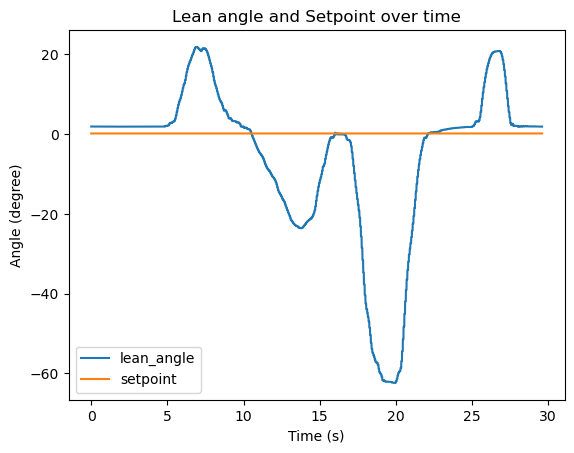

In [7]:
lean_angle = get_graphable_data(data, "lean_angle", "data")
lean_angle_t = time['lean_angle']

setpoint = DESIRED_ANGLE
setpoint_array = np.ones(lean_angle.shape) * setpoint

#graph 1
plt.figure()
plt.plot(lean_angle_t, lean_angle)
plt.plot(lean_angle_t, setpoint_array)

plt.title("Lean angle and Setpoint over time")
plt.xlabel("Time (s)")
plt.ylabel("Angle (degree)")
plt.legend(["lean_angle", "setpoint"])


Text(0.5, 1.0, 'Q Axis Current of motors')

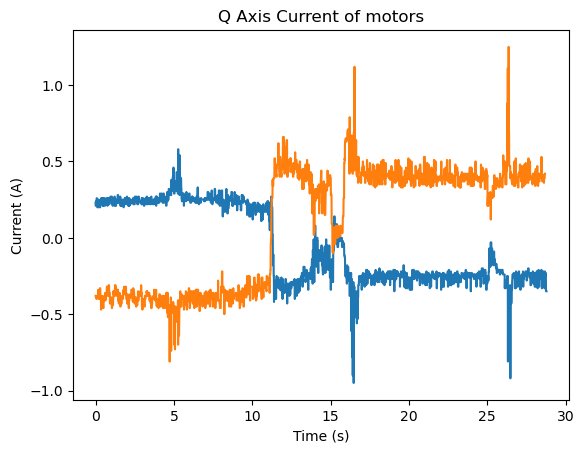

In [8]:
current0 = get_graphable_data(data, "motor0", "q_current")
current0_t = time["motor0"]

current1 = get_graphable_data(data, "motor1", "q_current")
current1_t = time["motor1"]

fig1, ax1 = plt.subplots()
ax1.plot(current0_t, current0)
ax1.plot(current1_t, current1)
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Current (A)")
ax1.set_title("Q Axis Current of motors")


Text(0.5, 1.0, 'Tuning Parameters')

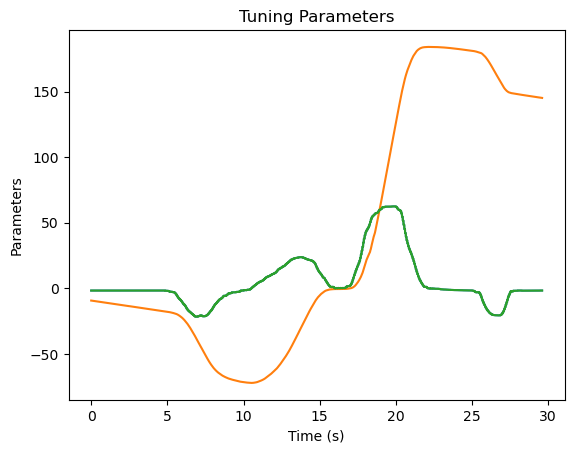

In [9]:
kp = get_graphable_data(data, "tuning", "kp")
ki = get_graphable_data(data, "tuning", "ki")
kd = get_graphable_data(data, "tuning", "kd")

tune_t = time["tuning"]


fig2, ax2 = plt.subplots()
ax2.plot(tune_t, kp)
ax2.plot(tune_t, ki)
ax2.plot(tune_t, kd)
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Parameters")
ax2.set_title("Tuning Parameters")